In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import subprocess

#%matplotlib inline
#import math
#from tqdm import tqdm


## Generate Cluster Analysis files, una tantum   (copied to makeClustersLists.py)

In [247]:
# Look for all Traj files

dens=0.10
filestringList = subprocess.check_output("ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens{:.3f}_eT*/TrajLog_*_1[0-9][0-9].xyz | sed 's/.*Test_2\///' ".format(dens), shell=True)
#filestringList = subprocess.check_output("ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens{:.3f}_eT30.00/TrajLog_*_115.xyz | sed 's/.*Test_2\///' ".format(dens), shell=True)
filestringList=filestringList.split()
filestringList=[a.decode("utf-8") for a in filestringList]
print(filestringList)

folder='/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2'


['Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_100.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_101.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_102.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_103.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_104.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_105.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_106.xyz', 'Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_107.xyz', 'Result

In [248]:
from ovito.io import *
from ovito.modifiers import *
from ovito.data import *
from ovito.pipeline import *
from ovito.vis import *
import PySide6.QtCore
import os.path

nA = 10000

for filestring in filestringList:
    print(filestring)
    filepattern = subprocess.check_output(
        " echo {:s} | sed 's/.*\/TrajLog_//' | sed 's/.xyz//'".format(folder + '/' + filestring), shell=True)
    filepattern = filepattern.split()[0]
    filepattern = filepattern.decode("utf-8")
    ClusterStatisticsFile = '{}/Analysis/ClustersFiles/ClustersStatistics_{}.dat'.format(folder, filepattern)
    laststring = subprocess.check_output("tail -n5 {}/Results_*/Log_{}.dat".format(folder, filepattern), shell=True)

    #if (os.path.isfile(ClusterStatisticsFile)==False) & ("Total wall time" in laststring.decode("utf-8")):
    #if ("Total wall time" in laststring.decode("utf-8")):        # use this instead of previous line to overwrite file
    #if (os.path.isfile(ClusterStatisticsFile)==False):
    if True:  # rifugium peccatorum, needs to run again once sims are finished

        # Data import:
        pipeline = import_file('{}/{}'.format(folder, filestring), multiple_frames=True)

        # Select type:
        pipeline.modifiers.append(SelectTypeModifier(types={2, 3}))

        # Delete selected:
        pipeline.modifiers.append(DeleteSelectedModifier())

        # Cluster analysis:
        pipeline.modifiers.append(ClusterAnalysisModifier(
            cutoff=1.15,
            sort_by_size=True,
            unwrap_particles=True,  # needs to stay true, otherwise omega&AngMom per cluster will be wrong
            compute_com=True,
            compute_gyration=True,
            cluster_coloring=True))

        # Export Cluster analysis
        AvgClusterSize = []
        StdClusterSize = []
        for ThisFrame in range(pipeline.source.num_frames):
            data = pipeline.compute(frame=ThisFrame)
            print(data.attributes['Timestep'])
            if data.particles.count != nA:
                print("Missing atoms (only {:d} present) in timestep {:d}, file\n {:s}".format(data.particles.count, data.attributes['Timestep'], filestring))            
                AvgClusterSize.append(data.tables['clusters'].xy()[:, 1].mean())
                StdClusterSize.append(data.tables['clusters'].xy()[:, 1].std())
                break
            #data.particles_.positions[:, 2] = 0
            ClustersListFile = '{}/Analysis/ClustersFiles/ClustersList_{}_ts{:d}.dat'.format(folder, filepattern, data.attributes['Timestep'])
            # export_file(data.tables['clusters'], '{}/Analysis/ClustersFiles/ClustersList_{}_ts{:d}.dat'.format(folder,filepattern,data.attributes['Timestep']),'txt/table', precision=3)
            ClustersOvito = data.tables['clusters']
            assert (ClustersOvito.x[:] == np.arange(1, len(ClustersOvito.x[:]) + 1, 1)).all(), "ClusterIDs are weird... Add additional check in the ClustersRotation computation (AngMom and Omega) "
            ClustersDataDf = pd.DataFrame(ClustersOvito.xy(), columns=['ClusterID', 'Size'])
            ClustersDataDf['Xcm'] = ClustersOvito['Center of Mass'][:, 0]
            ClustersDataDf['Ycm'] = ClustersOvito['Center of Mass'][:, 1]
            ClustersDataDf['Gxx'] = ClustersOvito['Gyration Tensor'][:, 0]  
                    # the gyration tensor is computed as in lammps, for instance: Gxx =  1/M sum(mi xi^2), where xi is the position of particle i wrt the CM of its cluster
            ClustersDataDf['Gyy'] = ClustersOvito['Gyration Tensor'][:, 1]
            ClustersDataDf['Gxy'] = ClustersOvito['Gyration Tensor'][:, 3]
            ClustersDataDf['Iz'] = (ClustersOvito['Gyration Tensor'][:, 0] + ClustersOvito['Gyration Tensor'][:, 1]) * ClustersOvito['Cluster Size'][:]
            ClustersDataDf['Rg'] = np.sqrt(ClustersDataDf['Gxx'].values + ClustersDataDf['Gyy'].values)
            ClustersRotation = np.zeros((len(ClustersOvito.x[:]), 2))  # column 0 is ang mom, 1 is omega
            for i in range(0, data.particles.count):
                AtID = data.particles.identifiers[i]
                ClID = data.particles.cluster[i]
                rowID = ClID - 1
                ClData = ClustersDataDf[ClustersDataDf['ClusterID'] == ClID].iloc[0]
                RelativePos = data.particles.positions[i] - np.array([ClData['Xcm'], ClData['Ycm'], 0])  # z coordinate is meaningless here
                Velocity = data.particles.velocities[i]
                ClustersRotation[rowID, 0] += 1.0 * (RelativePos[0] * Velocity[1] - RelativePos[1] * Velocity[0])
                ClustersRotation[rowID, 1] += (RelativePos[0] * Velocity[1] - RelativePos[1] * Velocity[0]) / (RelativePos[0] ** 2 + RelativePos[1] ** 2 + 1e-100)
            for rowID in range(0, len(ClustersOvito.x[:])):
                ClID = rowID + 1
                ClSize = ClustersDataDf[ClustersDataDf['ClusterID'] == ClID].iloc[0].Size
                ClustersRotation[rowID, 1] /= ClSize
            ClustersDataDf['AngMomz'] = ClustersRotation[:, 0]
            ClustersDataDf['Omegaz'] = ClustersRotation[:, 1]
            ClustersDataDf['Omegaz'] = ClustersDataDf['Omegaz'].map(lambda x: '{:.3e}'.format(x))
            ClustersDataDf.to_csv(ClustersListFile, index=False, header=True, sep=' ', float_format='{:.3f}'.format)

            # data.attributes['AvgClusterSize']=data.tables['clusters'].xy()[:,1].mean()
            # data.attributes['StdClusterSize']=data.tables['clusters'].xy()[:,1].std()

            AvgClusterSize.append(data.tables['clusters'].xy()[:, 1].mean())
            StdClusterSize.append(data.tables['clusters'].xy()[:, 1].std())

        export_file(pipeline, ClusterStatisticsFile,
                    'txt/attr', precision=3, columns=["Timestep", "ClusterAnalysis.largest_size"], multiple_frames=True)

        with open(ClusterStatisticsFile, 'r') as txt:
            lines = txt.readlines()
        lines[0] = lines[0][:-1] + ' "AvgClusterSize" "StdClusterSize"\n'
        for i in range(1, len(lines)):
            lines[i] = lines[i][:-2] + ' {:.3f} {:+.3f}\n'.format(AvgClusterSize[i - 1], StdClusterSize[i - 1])
        with open(ClusterStatisticsFile, 'w') as f:
            f.writelines(lines)
        print("Written " + ClusterStatisticsFile)

Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_100.xyz
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
2000000
3000000
4000000
5000000
Written /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Analysis/ClustersFiles/ClustersStatistics_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_100.dat
Results_qA5_dp0.50_dens0.100_eT0.00/TrajLog_qA5_dp0.50_dens0.10_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_101.xyz
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
2000000
3000000
4000000
5000000
Written /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Analysis/ClustersFiles/ClustersStatistics_qA5_dp0.50_dens0.10_eT0.00_nA1000

In [5]:
# Erase files created by mistake for simulations that didn't complete time
# (it shouldn't happen anymore, because now there's a check on this in the previous cell)

# Uncomment if needed
'''
for filestring in filestringList:
    folder='/Users/ivan/Dropbox/Mac/Documents/CurvatureLAT/Simulations/CylPla'
    laststring = subprocess.check_output("tail -n5 {}/Results/Log_{}.dat".format(folder,filestring), shell=True)
    ClusterStatisticsFile='{}/Analysis/ClustersFiles/ClustersStatistics_{}.dat'.format(folder,filestring)
    if ("Total wall time" not in laststring.decode("utf-8")) and (os.path.isfile(ClusterStatisticsFile)==True):
        print("Removed "+filestring)
        subprocess.check_output("rm {}/Analysis/ClustersFiles/Clusters*_{}*".format(folder,filestring), shell=True)    
'''

## Import ClusterList data

In [176]:
def createkey(eT,ts,real):
    assert isinstance(eT,float)
    assert isinstance(ts, int)
    assert isinstance(real,int)
    return 'eT{:.2f}_ts{:d}_{:d}'.format(eT,ts,real)

In [177]:
import re
r1 = re.compile('[_]')
r2 = re.compile(r'(([-+]?\d+\.\d+)|([-+]?\d+))')

datadic={}
eTList=[]
tsList=[]
realList=[]

fileList = subprocess.check_output("ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Analysis/ClustersFiles/ClustersList_qA5_dp0.50_dens0.20_eT*_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_1[0-9][0-9]_ts*.dat", shell=True)
fileList=fileList.split()
fileList=[a.decode("utf-8") for a in fileList]

for file in fileList:
    filepattern = subprocess.check_output(" echo {:s} | sed 's/.*\/ClustersList_//' | sed 's/.dat//'".format(folder+'/'+file), shell=True)
    filepattern=filepattern.split()[0]
    filepattern = filepattern.decode("utf-8")
    for s in r1.split(filepattern):
        if s.startswith('eT'):
            eT=float(r2.split(s)[1])
        if s.startswith('ts'):
            ts=int(r2.split(s)[1])
        if s[0].isdigit():
            real=int(s)
    Data=pd.read_csv(file, sep=' ', usecols=['Size','Rg','AngMomz','Omegaz','Iz'])
    key=createkey(eT,ts,real)
    print(key)
    datadic[key]=Data
    if eT not in eTList:
        eTList.append(eT)
    if ts not in tsList:
        tsList.append(ts)
    if real not in realList:
        realList.append(real)


eT0.00_ts0_100
eT0.00_ts1000_100
eT0.00_ts10000_100
eT0.00_ts100000_100
eT0.00_ts1000000_100
eT0.00_ts2000_100
eT0.00_ts20000_100
eT0.00_ts200000_100
eT0.00_ts2000000_100
eT0.00_ts3000_100
eT0.00_ts30000_100
eT0.00_ts300000_100
eT0.00_ts3000000_100
eT0.00_ts4000_100
eT0.00_ts40000_100
eT0.00_ts400000_100
eT0.00_ts4000000_100
eT0.00_ts5000_100
eT0.00_ts50000_100
eT0.00_ts500000_100
eT0.00_ts5000000_100
eT0.00_ts6000_100
eT0.00_ts60000_100
eT0.00_ts600000_100
eT0.00_ts7000_100
eT0.00_ts70000_100
eT0.00_ts700000_100
eT0.00_ts8000_100
eT0.00_ts80000_100
eT0.00_ts800000_100
eT0.00_ts9000_100
eT0.00_ts90000_100
eT0.00_ts900000_100
eT0.00_ts0_101
eT0.00_ts1000_101
eT0.00_ts10000_101
eT0.00_ts100000_101
eT0.00_ts1000000_101
eT0.00_ts2000_101
eT0.00_ts20000_101
eT0.00_ts200000_101
eT0.00_ts2000000_101
eT0.00_ts3000_101
eT0.00_ts30000_101
eT0.00_ts300000_101
eT0.00_ts3000000_101
eT0.00_ts4000_101
eT0.00_ts40000_101
eT0.00_ts400000_101
eT0.00_ts4000000_101
eT0.00_ts5000_101
eT0.00_ts50000_101
eT0

## Fractal dimension

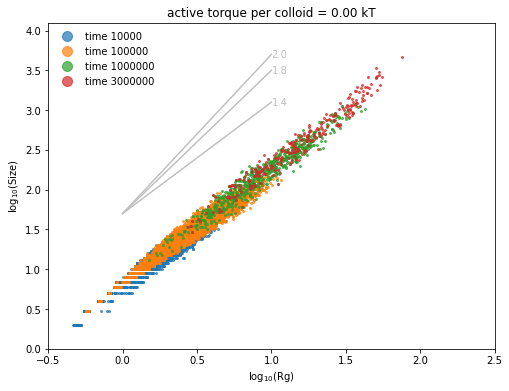

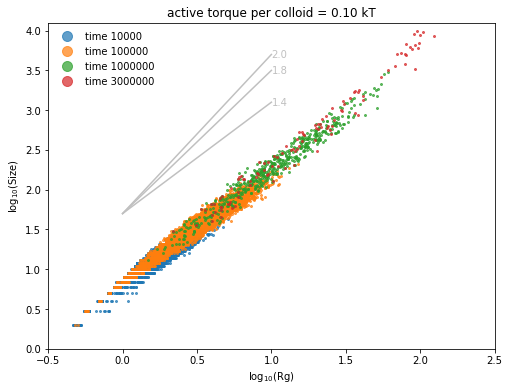

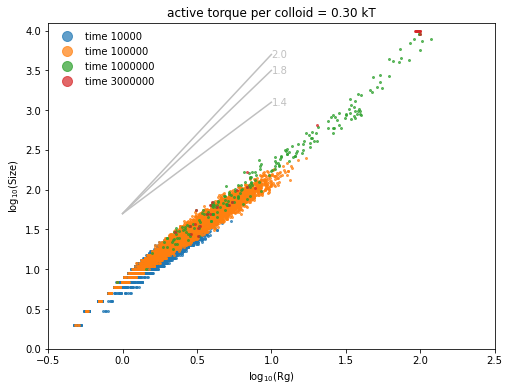

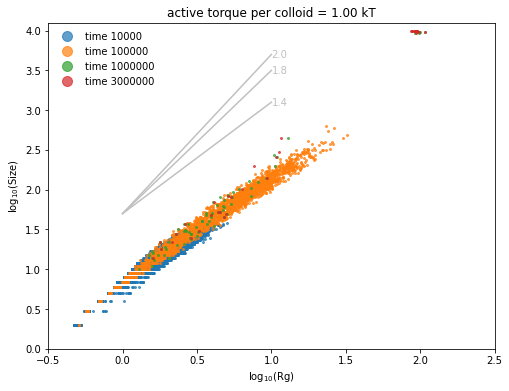

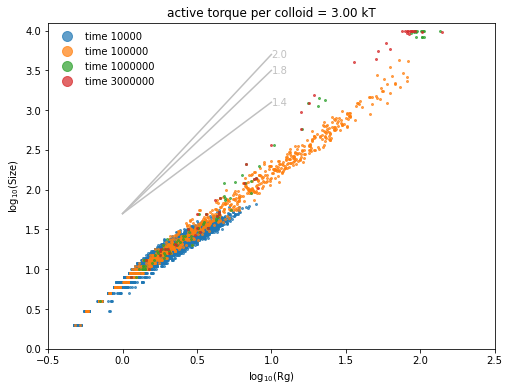

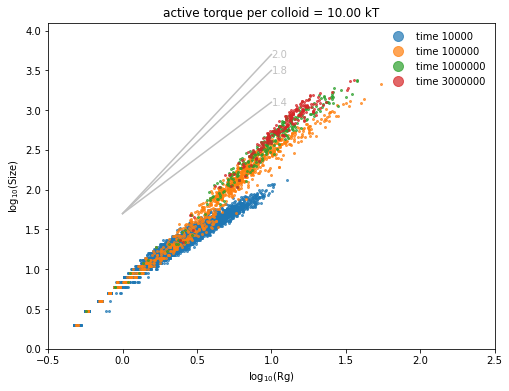

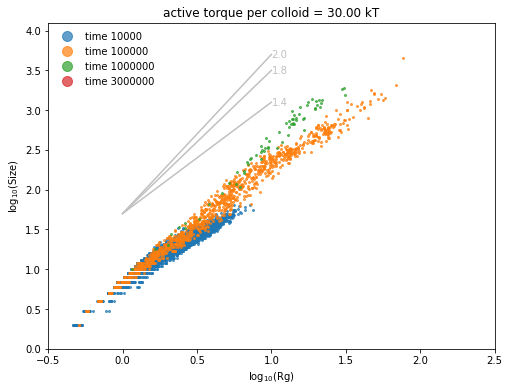

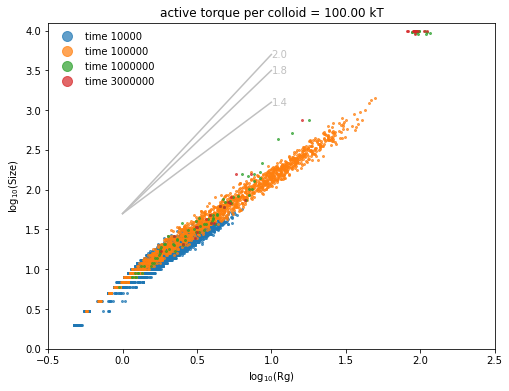

In [15]:
eTList.sort()
tsList.sort()
realList.sort()

SizeCutoff=1

for eT in eTList:
    plt.figure(figsize=(8,6))
    for ts in [10000, 100000, 1000000, 3000000]: #[10000,30000,100000,300000,1000000, 3000000]:
        LogSize=[]
        LogRg=[]
        for real in realList:
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                df=df[df['Size']>SizeCutoff]
                LogSize.extend(np.log10(df['Size'].values))
                LogRg.extend(np.log10(df['Rg'].values))
        plt.plot(LogRg,LogSize,'o', ms=2, label='time {:d}'.format(ts), alpha=0.7)
    plt.xlabel(r'log$_{10}$(Rg)')
    plt.ylabel('log$_{10}$(Size)')
    plt.ylim(0,4.1)
    plt.xlim(-0.5,2.5)
    lgnd=plt.legend(frameon=False, markerscale=5)
    plt.title('active torque per colloid = {:.2f} kT'.format(eT))
    # plot lines
    xline=np.array([0,1])
    yshift=1.7
    for i in [1.4,1.8,2]:
        plt.plot(xline,np.log10((10**xline)**i)+yshift,color='silver')
        plt.annotate('{:.1f}'.format(i), [xline[1],(np.log10((10**xline)**i)+yshift)[1]],color='silver',va='center',ha='left')
    plt.savefig("Graphs/FractalDim_dens{:.2f}_eT{:.2f}.pdf".format(dens,eT))

## Cluster size distribution

"    plt.xlabel(r'log$_{10}$(Rg)')\n    plt.ylabel('log$_{10}$(Size)')\n    plt.ylim(0,4.1)\n    plt.xlim(-0.5,2.5)\n    lgnd=plt.legend(frameon=False, markerscale=5)\n    plt.title('active torque per colloid = {:.2f} kT'.format(eT))\n    "

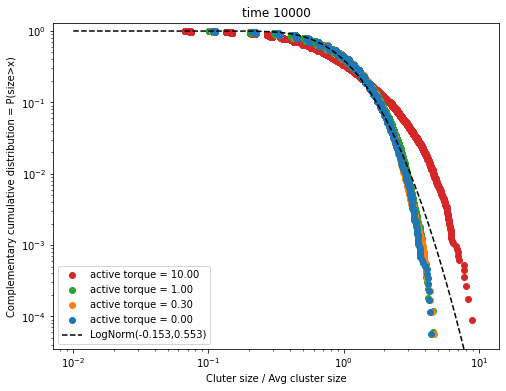

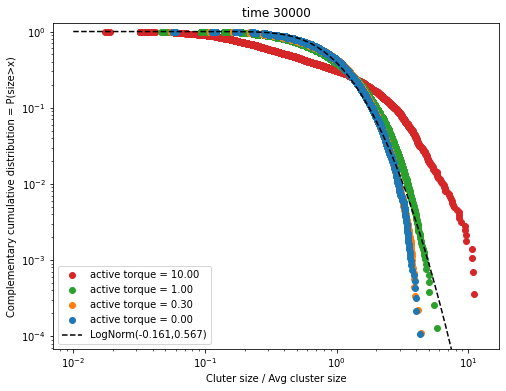

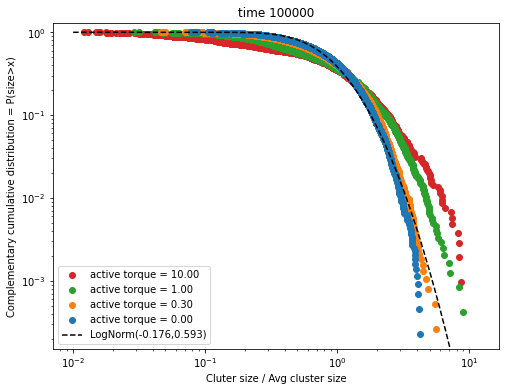

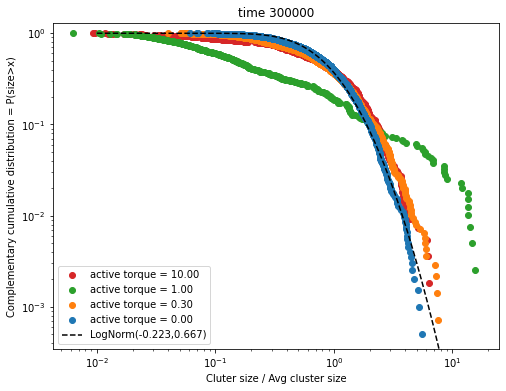

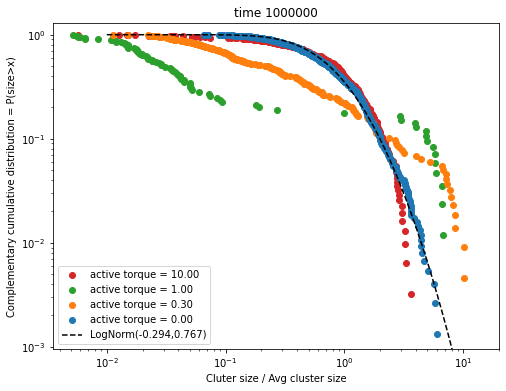

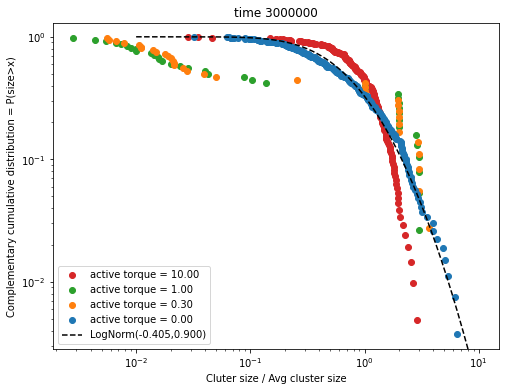

In [19]:
import seaborn as sns
from scipy.stats import lognorm
from scipy.special import erf

def lognormal_ComplCumDistr(x,mu,sigma):
    return 0.5-0.5*erf((np.log(x)-mu)/(sigma*np.sqrt(2)))


eTSubList=[0.0,0.3,1.0,10.0]
SizeCutoff=0

for ts in [10000,30000,100000,300000,1000000,3000000]:  #[10000,30000,100000,300000,1000000,3000000]:
    EcdfList=[]
    LegendList=[]
    plt.figure(figsize=(8,6))
    for eT in eTSubList:
        Size=[]
        Rg=[]
        for real in realList:
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                df=df[df['Size']>SizeCutoff]
                Size.extend(df['Size'].values/df['Size'].values.mean())
        EcdfList.append(Size)
        LegendList.append('{:.2f}'.format(eT))
        if eT==0.0:
            Std_eT0=np.array(Size).std()
    sns.ecdfplot(EcdfList,complementary=True,log_scale=True,marker='o',ls='None')
    plt.yscale('log')
    plt.ylim(None,1.3)
    plt.xlabel('Cluter size / Avg cluster size')
    plt.ylabel('Complementary cumulative distribution = P(size>x)')
    plt.title('time {:d}'.format(ts))
    
    # plot lognormal
    x=np.linspace(1e-2,10,1000)
    sigma=np.sqrt(np.log(Std_eT0**2 + 1))
    mu=-0.5*sigma**2  # impose that mean is 1
    plt.plot(x,lognormal_ComplCumDistr(x,mu,sigma),'--',color='k',label='LogNorm({:.3f},{:.3f})'.format(mu,sigma))
    
    #legend
    eTSubList.reverse()
    LegendList=['active torque = {:.2f}'.format(eT) for eT in eTSubList]
    eTSubList.reverse()
    LegendList.extend(['LogNorm({:.3f},{:.3f})'.format(mu,sigma)])
    lgnd=plt.legend(LegendList, loc='lower left')
    plt.savefig("Graphs/ECDF_dens{:.2f}_ts{:d}.pdf".format(dens,ts))

# plot lognormal
'''s=2.0
mean, var, skew, kurt = lognorm.stats(s, moments='mvsk')
x = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
plt.plot(x, lognorm.pdf(x, s),'r-', lw=2, alpha=0.6, label='lognorm pdf')
'''

'''    plt.xlabel(r'log$_{10}$(Rg)')
    plt.ylabel('log$_{10}$(Size)')
    plt.ylim(0,4.1)
    plt.xlim(-0.5,2.5)
    lgnd=plt.legend(frameon=False, markerscale=5)
    plt.title('active torque per colloid = {:.2f} kT'.format(eT))
    '''

## Cluster growth

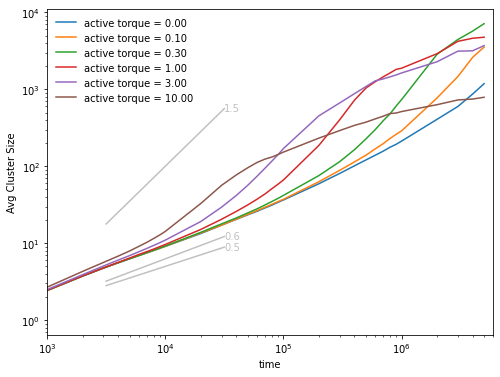

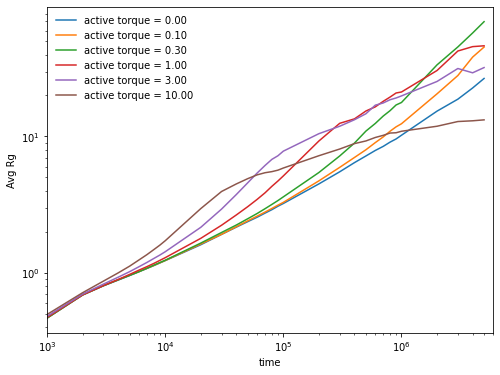

In [41]:
tsList.sort()
eTList.sort()

fig1=plt.figure(figsize=(8,6))
fig2=plt.figure(figsize=(8,6))

for eT in eTList[:-2]:
    #plt.figure(figsize=(8,6))
    AvgSize=[]
    StdSize=[]
    AvgRg=[]
    StdRg=[]
    for ts in tsList: #[10000,30000,100000,300000,1000000, 3000000]:
        Sizes=[]
        Rgs=[]
        for real in realList:
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                #df=df[df['Size']>SizeCutoff]
                Sizes.extend(df['Size'].values)
                Rgs.extend(df['Rg'].values)
        AvgSize.append(np.array(Sizes).mean())
        StdSize.append(np.array(Sizes).std())
        AvgRg.append(np.array(Rgs).mean())
        StdRg.append(np.array(Rgs).std())
    
    plt.figure(fig1)
    plt.errorbar(tsList,AvgSize,label='active torque = {:.2f}'.format(eT))#, yerr=StdSize)
    plt.figure(fig2)
    plt.errorbar(tsList,AvgRg,  label='active torque = {:.2f}'.format(eT))#, yerr=StdRg  )

    
plt.figure(fig1)    
plt.xlabel(r'time')
plt.ylabel('Avg Cluster Size')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3,6e6)
lgnd=plt.legend(frameon=False)
#plt.title('Average cluster size')
plt.savefig("Graphs/SizevsTime_dens{:.2f}.pdf".format(dens))

xline=np.array([3.5,4.5])
yshift=[0.05,0.03,0.0001]
j=-1
for i in [0.5,0.58, 1.5]:
    j+=1
    plt.plot((10**xline),((10**xline)**i)*yshift[j],color='silver')
    plt.annotate('{:.1f}'.format(i), [10**xline[1],((10**xline[1])**i)*yshift[j]],color='silver',va='center',ha='left')

    
plt.figure(fig2)    
plt.xlabel(r'time')
plt.ylabel('Avg Rg')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3,6e6)
lgnd=plt.legend(frameon=False)
plt.savefig("Graphs/RgvsTime_dens{:.2f}.pdf".format(dens))


## Distribution of omega at fixed time

/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_26064/8467587.py:40: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(AngMomz/Iz, label='time {:d}. Avg = {:f}'.format(ts, (AngMomz/Iz).mean()), alpha=0.7, range=[-2,2],bins=20)
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_26064/8467587.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figAngMomz=plt.figure(figsize=(8,6))
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_26064/8467587.py:36: RuntimeWarning: Mean of empty slice.
  plt.hist(Omegaz, label='time {:d}. Avg = {:f}'.format(ts,Omegaz.mean()), alpha=0.7, range=[-2,2],bins=20)
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 576x432 with 0 Axes>

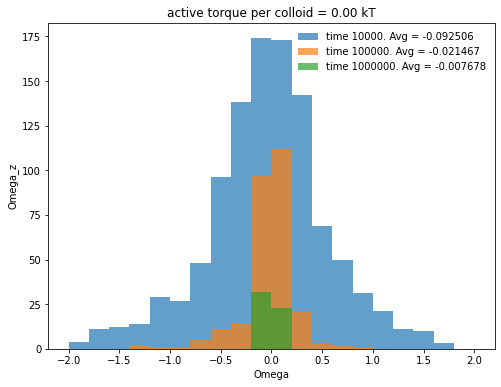

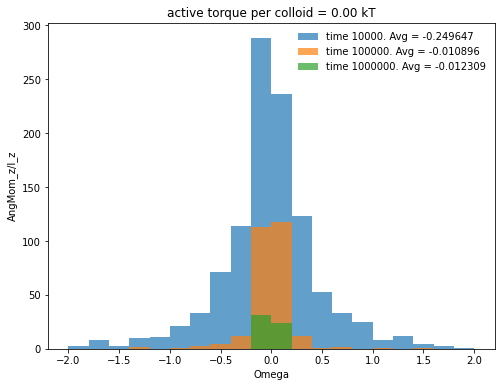

<Figure size 576x432 with 0 Axes>

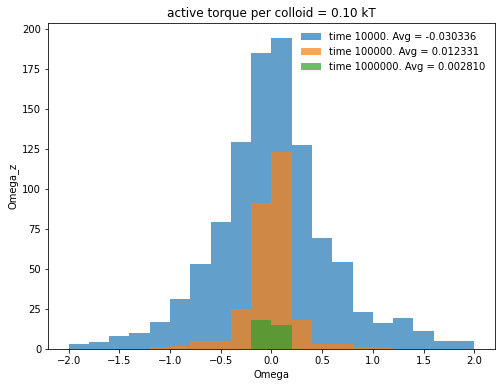

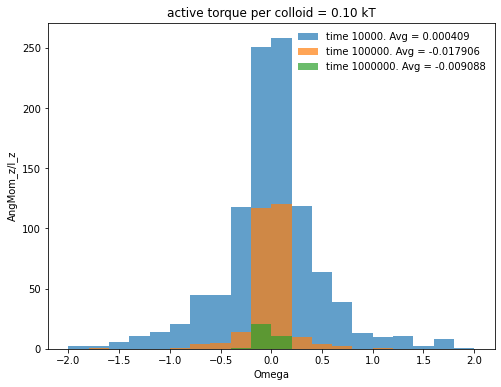

<Figure size 576x432 with 0 Axes>

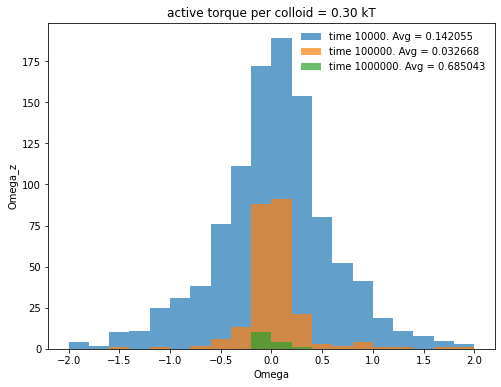

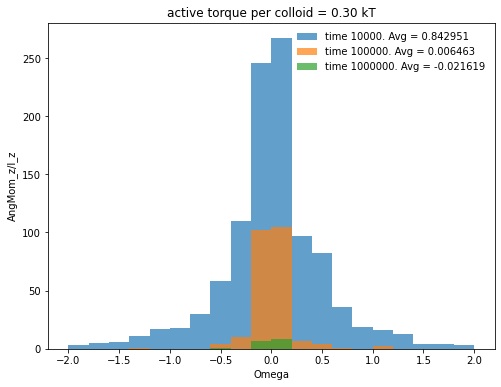

<Figure size 576x432 with 0 Axes>

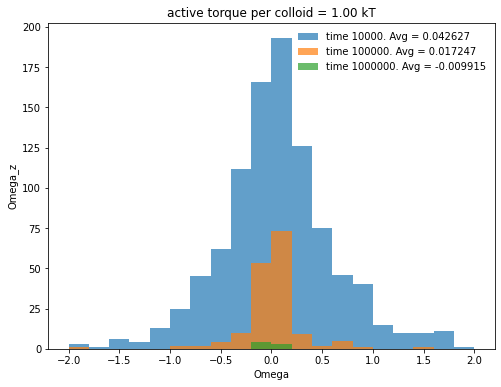

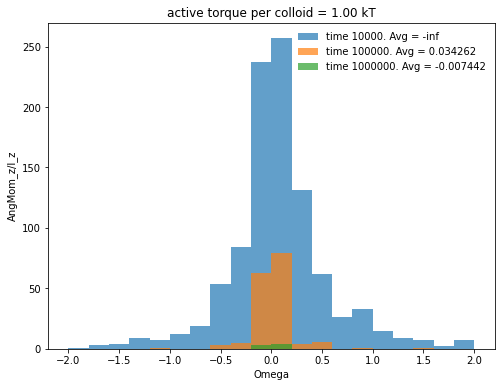

<Figure size 576x432 with 0 Axes>

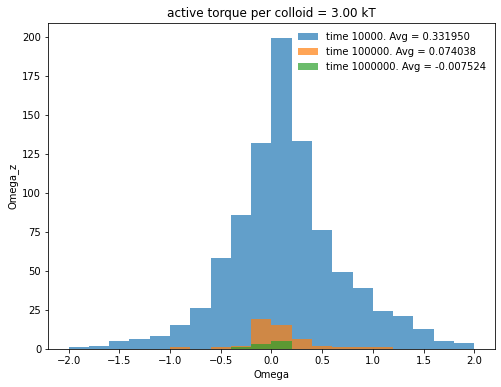

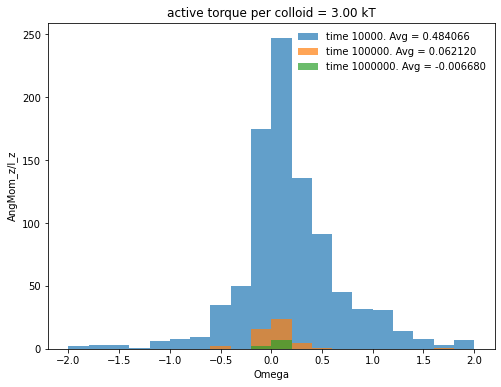

<Figure size 576x432 with 0 Axes>

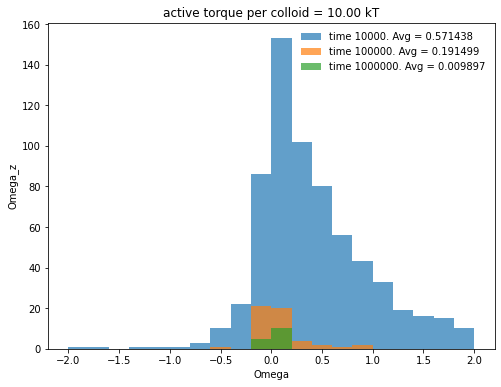

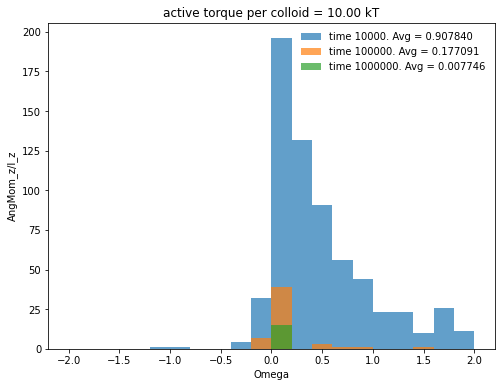

<Figure size 576x432 with 0 Axes>

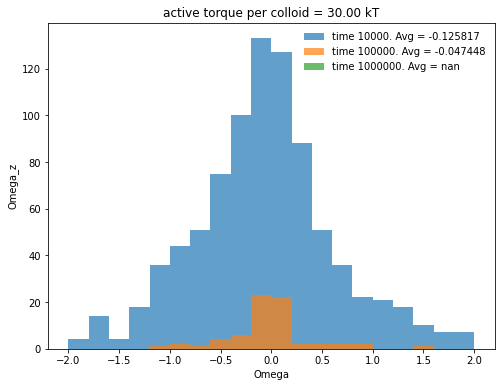

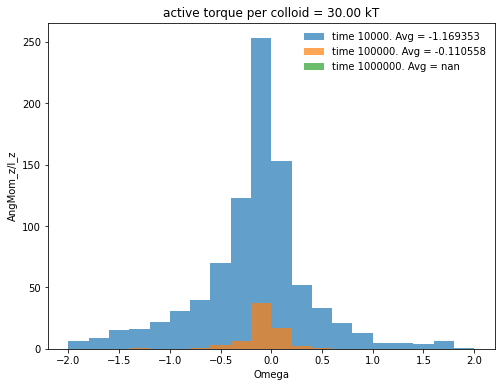

<Figure size 576x432 with 0 Axes>

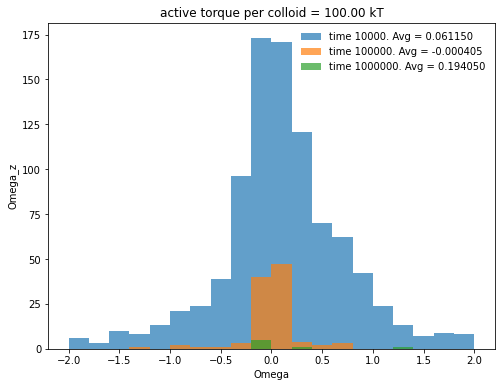

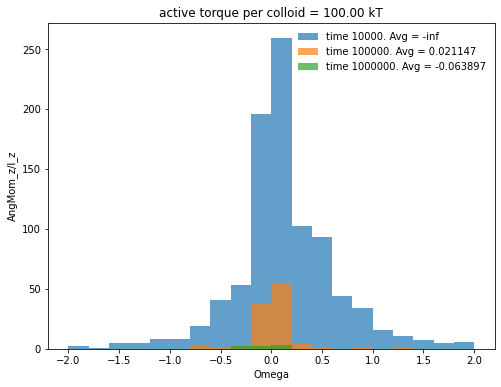

In [61]:
eTList.sort()
tsList.sort()
realList.sort()

SizeCutoff=1

for eT in eTList:
    figOmegaz=plt.figure(figsize=(8,6))
    figOAngMomz=plt.figure(figsize=(8,6))
    figAngMomz=plt.figure(figsize=(8,6))
    for ts in [10000,100000,1000000]:
        for real in realList:
            Size=[]
            Rg=[]
            Omegaz=[]
            AngMomz=[]
            Iz=[]
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                df=df[df['Size']>SizeCutoff]
                Size.extend(df['Size'].values)
                Rg.extend(df['Rg'].values)
                Omegaz.extend(df['Omegaz'].values)
                AngMomz.extend(df['AngMomz'].values)
                Iz.extend(df['Iz'].values)
        Size=np.array(Size)
        Rg=np.array(Rg)
        AngMomz=np.array(AngMomz)
        Omegaz=np.array(Omegaz)
        Iz=np.array(Iz)
        #print(Iz)
        plt.figure(figOmegaz)
        plt.ylabel('Omega_z')
        #histo,bins=plt.histogram(Omegaz)
        plt.hist(Omegaz, label='time {:d}. Avg = {:f}'.format(ts,Omegaz.mean()), alpha=0.7, range=[-2,2],bins=20)
        
        plt.figure(figOAngMomz)
        plt.ylabel('AngMom_z/I_z')
        plt.hist(AngMomz/Iz, label='time {:d}. Avg = {:f}'.format(ts, (AngMomz/Iz).mean()), alpha=0.7, range=[-2,2],bins=20)
        
        #plt.figure(figAngMomz)
        #plt.ylabel('AngMom_z')
        #plt.hist(AngMomz*Size, label='time {:d}. Avg = {:f}'.format(ts, (AngMomz/Iz).mean()), alpha=0.7,bins=20)
        
    for fig in [figOmegaz,figOAngMomz]:
        plt.figure(fig)
        #plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel(r'Omega')
        #plt.ylim(None,20)
        #plt.xlim(-0.5,2.5)
        lgnd=plt.legend(frameon=False, markerscale=5)
        plt.title('active torque per colloid = {:.2f} kT'.format(eT))
        # plot lines
        xline=np.array([1,10])
        yshift=2
        expList=np.array([-2.0]) #*(2*(fig==figOmegaz)-1)
        for i in expList:
            #plt.plot(xline,yshift*(xline**i),color='silver')
            plt.annotate('{:.1f}'.format(i), [xline[1],(np.log10((10**xline)**i)+yshift)[1]],color='silver',va='center',ha='left')
        #plt.savefig("Graphs/OmegazvsRg_dens{:.2f}_eT{:.2f}.pdf".format(dens,eT))

## Omega vs Size/Rg

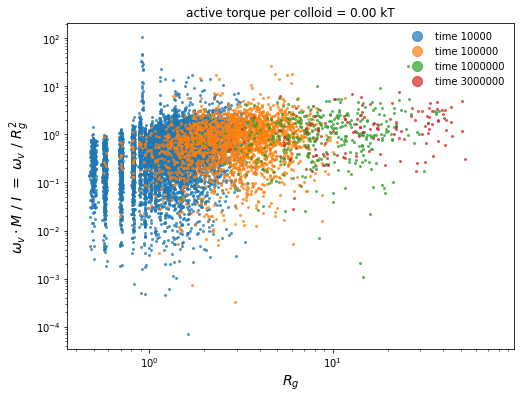

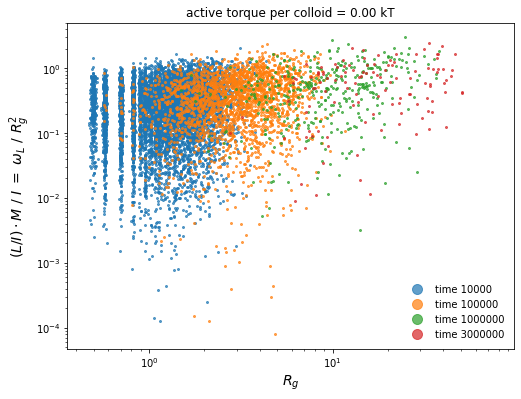

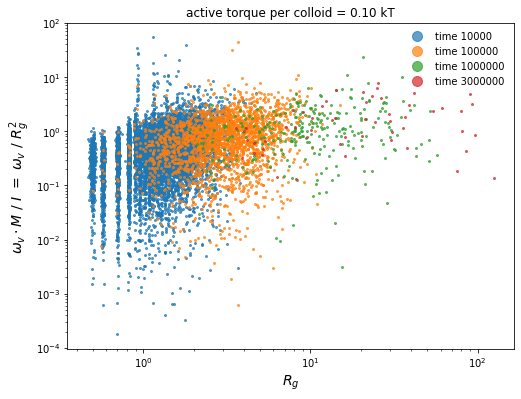

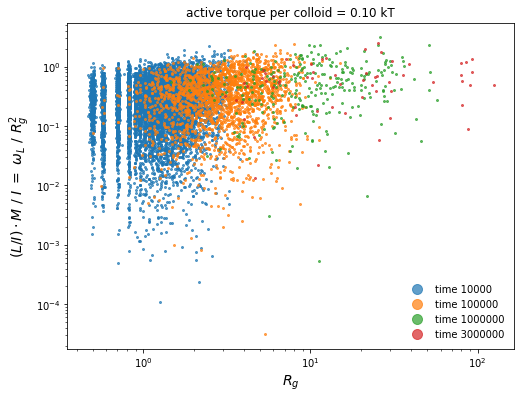

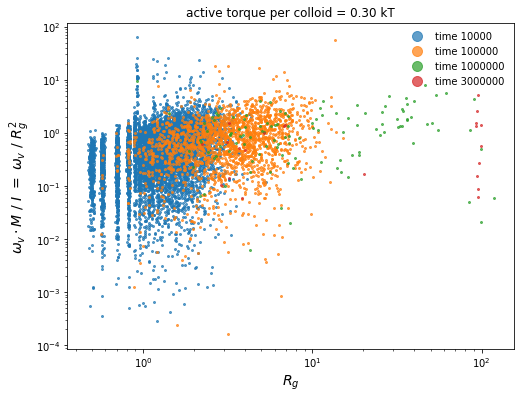

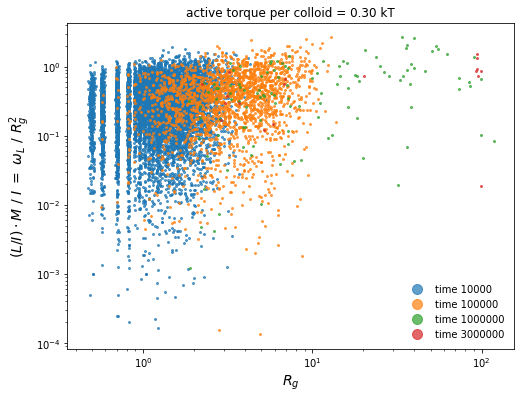

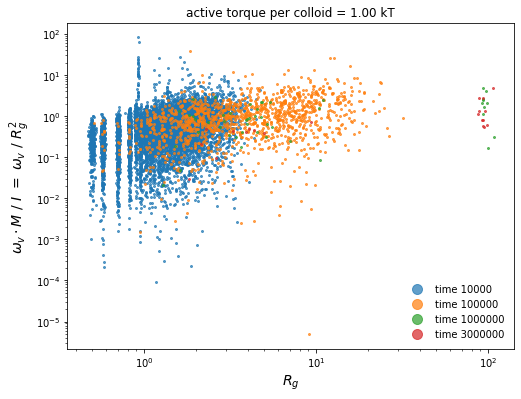

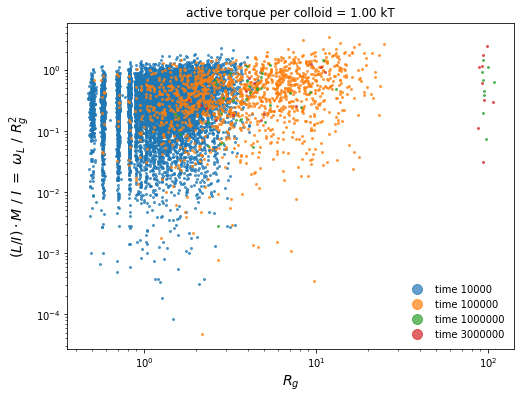

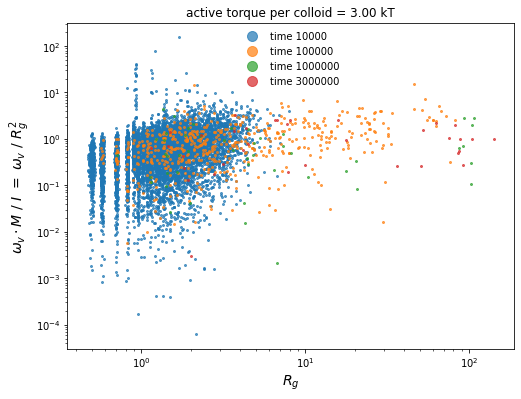

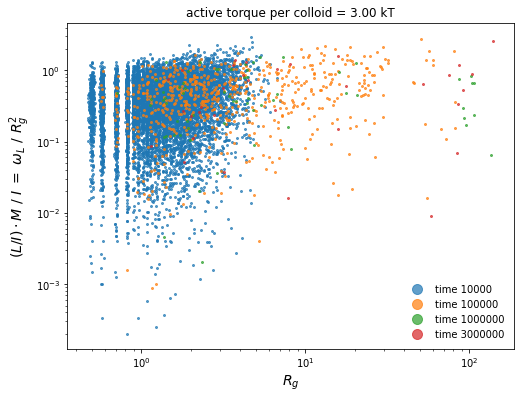

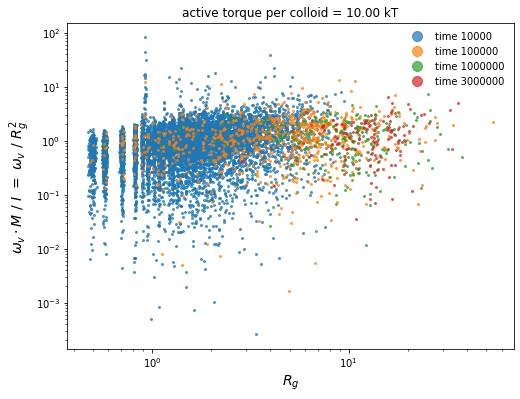

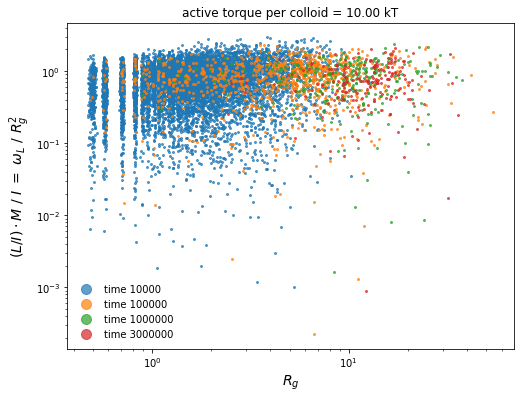

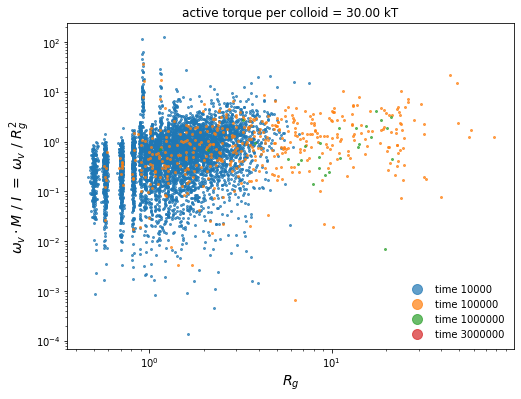

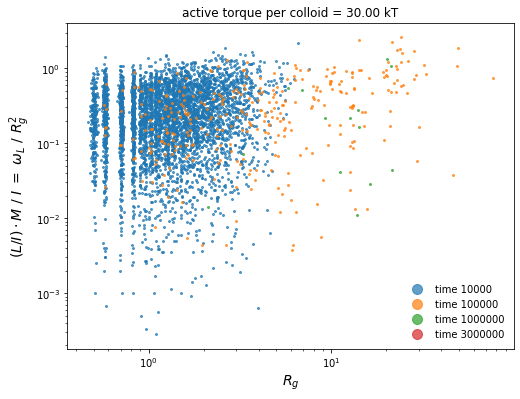

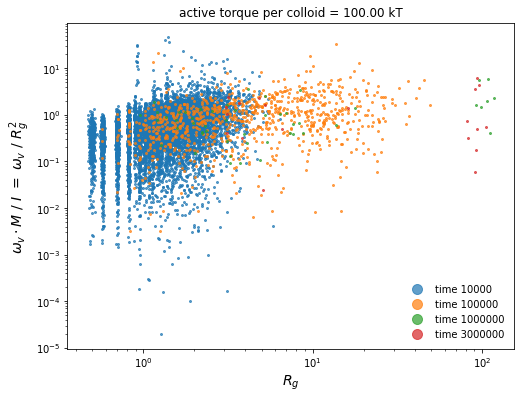

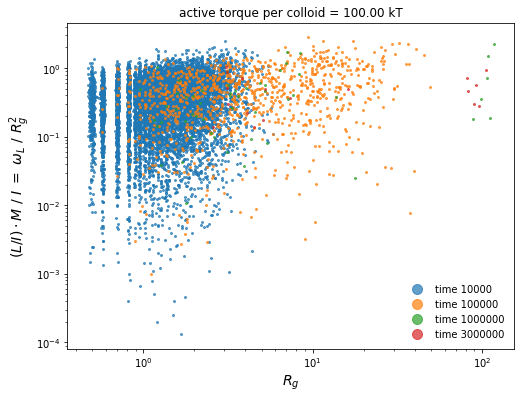

In [239]:
eTList.sort()
tsList.sort()
realList.sort()

SizeCutoff=1

for eT in eTList:
    figOmegaz=plt.figure(figsize=(8,6))
    figAngMomz=plt.figure(figsize=(8,6))
    for ts in [10000, 100000, 1000000, 3000000]: #[10000,30000,100000,300000,1000000, 3000000]:
        Size=[]
        Rg=[]
        Omegaz=[]
        AngMomz=[]
        Iz=[]
        for real in realList:
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                df=df[df['Size']>SizeCutoff]
                Size.extend(df['Size'].values)
                Rg.extend(df['Rg'].values)
                Omegaz.extend(df['Omegaz'].values)
                AngMomz.extend(df['AngMomz'].values)
                Iz.extend(df['Iz'].values)
        Size=np.array(Size)
        Rg=np.array(Rg)
        AngMomz=np.array(AngMomz)
        Omegaz=np.array(Omegaz)
        Iz=np.array(Iz)
        plt.figure(figOmegaz)
        plt.ylabel(r'$\omega_v \cdot M\ /\ I\ =\ \omega_v\ /\ R_g^2$ ', fontsize=14)
        plt.plot(Rg,Omegaz*Rg**2,'o', ms=2, label='time {:d}'.format(ts), alpha=0.7)
        plt.figure(figAngMomz)
        plt.ylabel(r'$(L/I)\cdot M\ /\ I\ =\ \omega_L\ /\ R_g^2$', fontsize=14)
        OmegazAM=AngMomz/(Size*Rg**2)
        plt.plot(Rg,OmegazAM*Rg**2,'o', ms=2, label='time {:d}'.format(ts), alpha=0.7)
        #plt.plot([10],AngMomz.sum(),'s', ms=5, label='time {:d}'.format(ts), alpha=0.7)

    for fig in [figOmegaz,figAngMomz]:
        plt.figure(fig)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$R_g$', fontsize=14)
        #plt.ylim(None,20)
        #plt.xlim(-0.5,2.5)
        lgnd=plt.legend(frameon=False, markerscale=5)
        plt.title('active torque per colloid = {:.2f} kT'.format(eT))
        # plot lines
        xline=np.array([1,10])
        yshift=2
        expList=np.array([-2.0]) #*(2*(fig==figOmegaz)-1)
        for i in expList:
            #plt.plot(xline,yshift*(xline**i),color='silver')
            plt.annotate('{:.1f}'.format(i), [xline[1],(np.log10((10**xline)**i)+yshift)[1]],color='silver',va='center',ha='left')
        #plt.savefig("Graphs/OmegazvsRg_dens{:.2f}_eT{:.2f}.pdf".format(dens,eT))

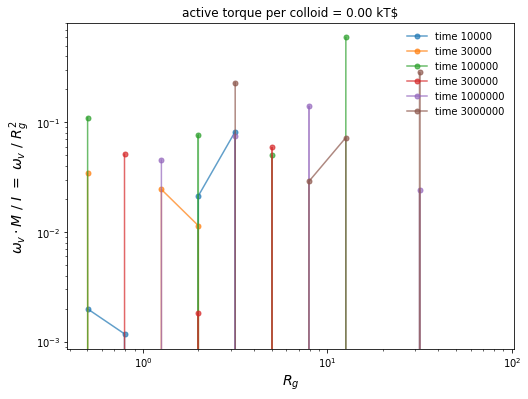

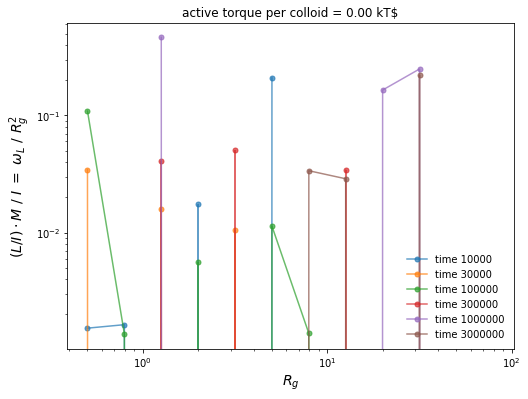

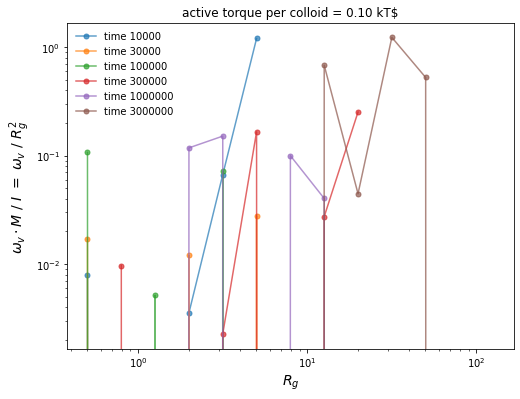

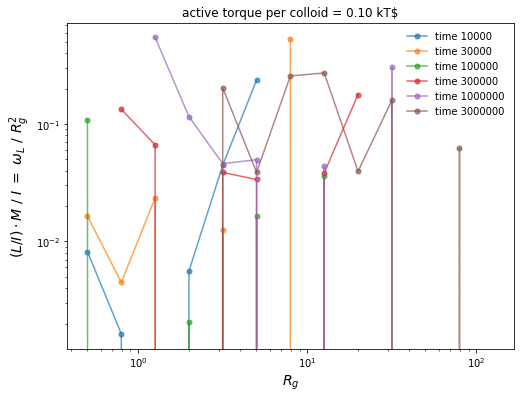

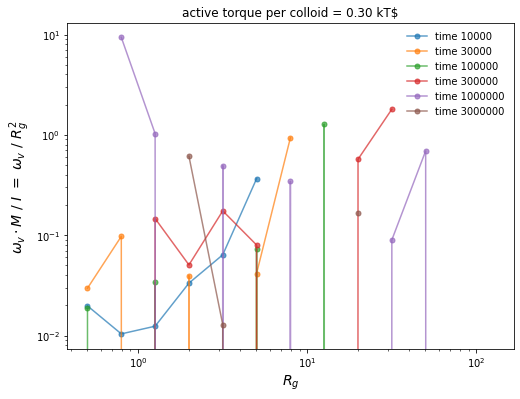

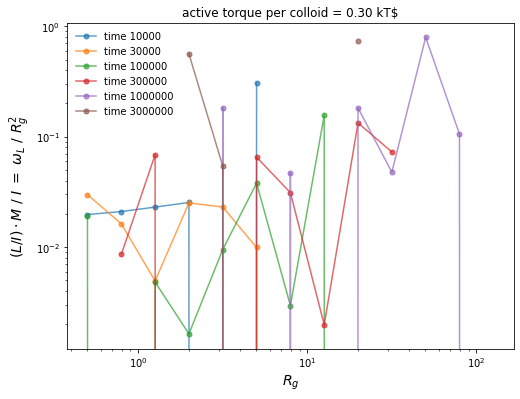

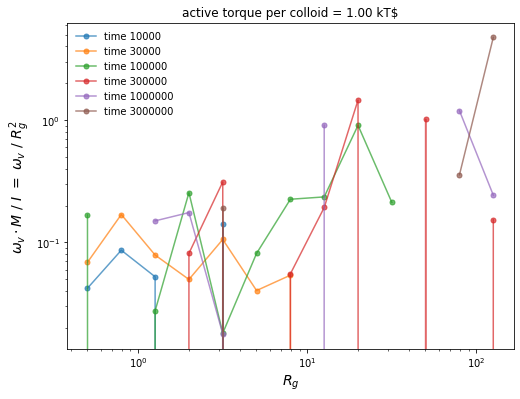

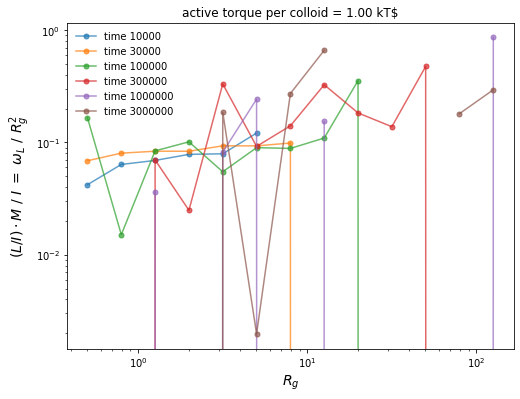

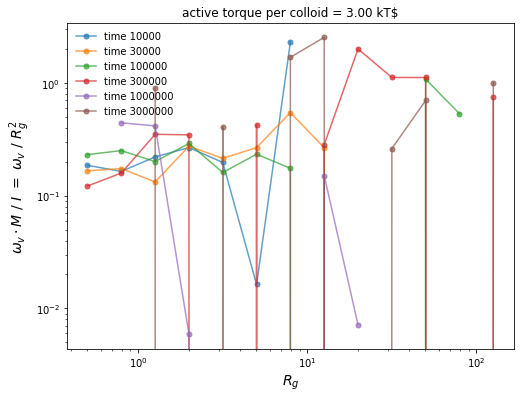

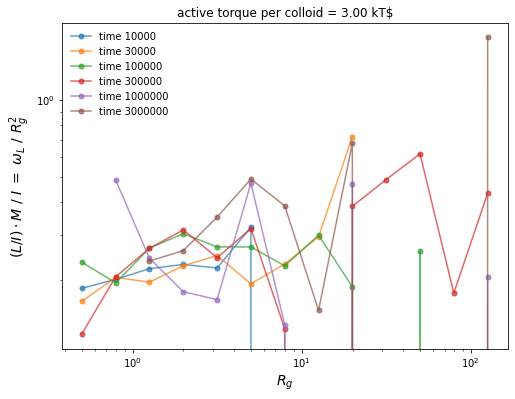

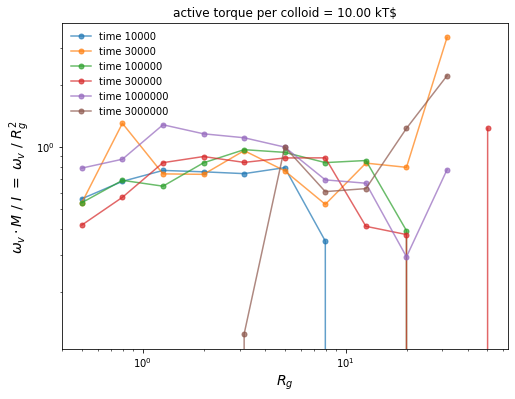

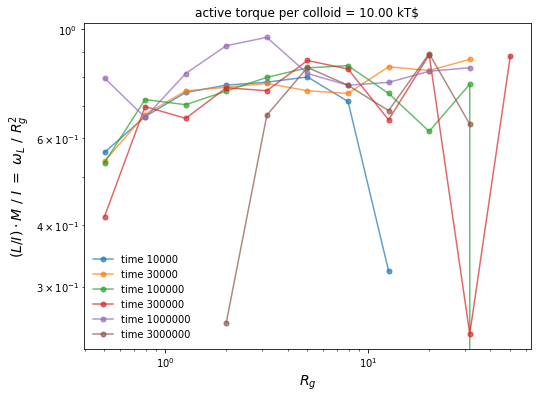

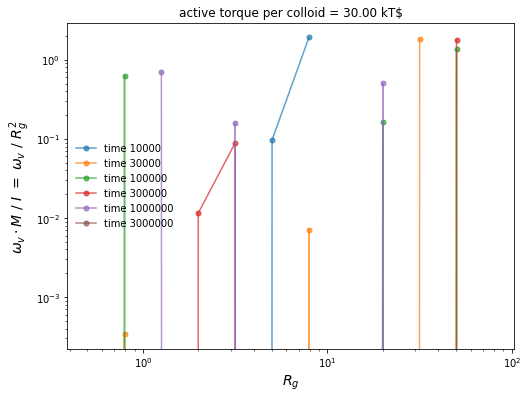

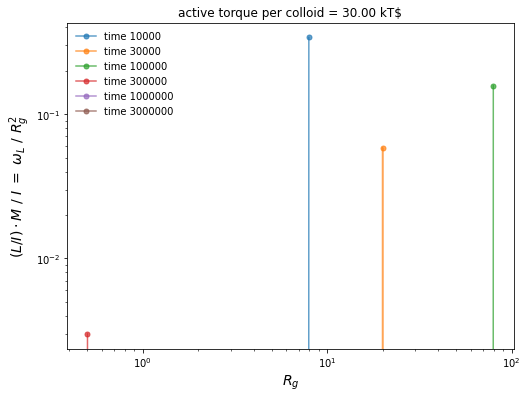

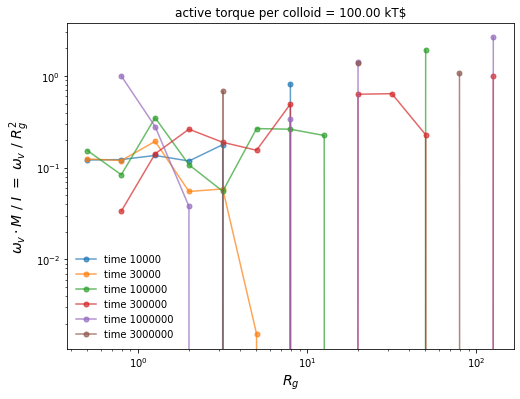

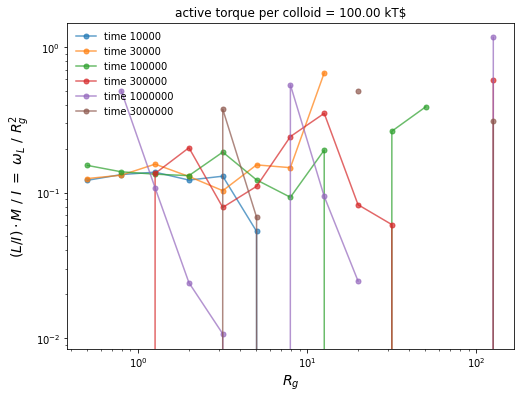

In [245]:
# Same as before, but data is organised in binds (by Rg) and omegas are averaged among all points in the same bin

eTList.sort()
tsList.sort()
realList.sort()

SizeCutoff=1

for eT in eTList:
    figOmegaz=plt.figure(figsize=(8,6))
    figAngMomz=plt.figure(figsize=(8,6))
    for ts in [10000, 30000, 100000, 300000, 1000000, 3000000]: #[10000,30000,100000,300000,1000000, 3000000]:
        Size=[]
        Rg=[]
        Omegaz=[]
        AngMomz=[]
        Iz=[]
        for real in realList:
            key=createkey(eT,ts,real)
            if key in datadic.keys():
                df=datadic[key]
                df=df[df['Size']>SizeCutoff]
                Size.extend(df['Size'].values)
                Rg.extend(df['Rg'].values)
                Omegaz.extend(df['Omegaz'].values)
                AngMomz.extend(df['AngMomz'].values)
                Iz.extend(df['Iz'].values)

        OmegazAM=np.array(AngMomz)/(np.array(Size)*(np.array(Rg)**2)) 
        DF=pd.DataFrame(np.array([Size,Rg,Omegaz,AngMomz,Iz,OmegazAM]).transpose(), columns=['Size','Rg','Omegaz','AngMomz','Iz','OmegazAM'])
        
        BinsPerDecade=5
        Rg_binned=np.array([10**(n/BinsPerDecade) for n in range(-BinsPerDecade,1+3*BinsPerDecade)])
        Omegaz_binned=[]
        Omegaz_binnedrescaled=[]
        OmegazAM_binned=[]
        OmegazAM_binnedrescaled=[]
        Rg_binnedcentred=[]
        for i in range(len(Rg_binned)-1):
            DF_thisbin=DF[(DF['Rg']>Rg_binned[i]) & (DF['Rg']<Rg_binned[i+1])]
            Omegaz_binned.append(DF_thisbin['Omegaz'].mean())
            OmegazAM_binned.append(DF_thisbin['OmegazAM'].mean())
            Omegaz_binnedrescaled.append((DF_thisbin['Omegaz']*DF_thisbin['Rg']**2).mean())
            OmegazAM_binnedrescaled.append((DF_thisbin['OmegazAM']*DF_thisbin['Rg']**2).mean())            
            Rg_binnedcentred.append(np.sqrt(Rg_binned[i]*Rg_binned[i+1]))
        Omegaz_binned=np.array(Omegaz_binned)
        OmegazAM_binned=np.array(OmegazAM_binned)
        Rg_binnedcentred=np.array(Rg_binnedcentred)     
        plt.figure(figOmegaz)
        plt.ylabel(r'$\omega_v \cdot M\ /\ I\ =\ \omega_v\ /\ R_g^2$ ', fontsize=14)
        plt.plot(Rg_binnedcentred,Omegaz_binnedrescaled,'o-', ms=5, label='time {:d}'.format(ts), alpha=0.7)
        plt.figure(figAngMomz)
        plt.ylabel(r'$(L/I)\cdot M\ /\ I\ =\ \omega_L\ /\ R_g^2$', fontsize=14)
        plt.plot(Rg_binnedcentred,OmegazAM_binnedrescaled,'o-', ms=5, label='time {:d}'.format(ts), alpha=0.7)
        #plt.plot([10],AngMomz.sum(),'s', ms=5, label='time {:d}'.format(ts), alpha=0.7)

    for fig in [figOmegaz,figAngMomz]:
        plt.figure(fig)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$R_g$', fontsize=14)
        #plt.ylim(None,20)
        #plt.xlim(-0.5,2.5)
        lgnd=plt.legend(frameon=False, markerscale=1)
        plt.title('active torque per colloid = {:.2f} kT$'.format(eT))
        # plot lines
        xline=np.array([1,10])
        yshift=2
        expList=np.array([-2.0]) #*(2*(fig==figOmegaz)-1)
        for i in expList:
            #plt.plot(xline,yshift*(xline**i),color='silver')
            plt.annotate('{:.1f}'.format(i), [xline[1],(np.log10((10**xline)**i)+yshift)[1]],color='silver',va='center',ha='left')
        #plt.savefig("Graphs/OmegazvsRg_dens{:.2f}_eT{:.2f}.pdf".format(dens,eT))

## Cython definitions

In [2]:
%load_ext Cython
#Don't merge this cell with the next. The next contains cython code, as it starts by %%cython

In [3]:
%%cython

# -*- coding: utf-8 -*-
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
# Copyright Guglielmo Saggiorato 2018
""" An "efficient" reader of LAMMPS dump files in cython.
Usage:
```import pyximport
pyximport.install()
from load_lammps import read_lammps
for time, column_names,data in read_lammps(filepath):
  pass
```
"""
__author__ = "Guglielmo Saggiorato" #Modified by Ivan Palaia
__copyright__ = "Copyright 2018, Guglielmo Saggiorato"
__credits__ = ["Guglielmo Saggiorato",]
__license__ = "GPLv3"
__version__ = "1.0"
__maintainer__ = "Guglielmo Saggiorato"
__email__ = "astyonax@gmail.com"
__status__ = "Production"

import numpy as np
cimport numpy as np
import pandas as pd
cimport cython
from libc.stdio cimport FILE, fopen, fwrite, fscanf, fclose, fprintf, fseek, ftell, SEEK_SET, rewind, fread

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def read_traj(str fname):
    """ Reads a LAMMPS dump file frame by frame yielding the data as a pandas DataFrame
This function automatically reads the fields/columns names and sets the pandas dataframe columns accordingly
For maximum performance, the bulk of the data is loaded without using any python object
In: fname [str]-- a file name as strings
Out: frame time [int], columns name [list], data [pandas.DataFrame], boxbounds [pandas.DataFrame]
Usage:
```import pyximport
pyximport.install()
from load_lammps import read_lammps
for time, column_names,data in read_lammps(filepath):
  pass
    """
    cdef str line,values
    cdef int i,N,T,j,cln,
    cdef list toarr,columns,
    cdef list columnsbox,
    cdef int Nbox,clnbox
    cdef double[:,:] data
    cdef double[:,:] box
    cdef double tmp
    cdef FILE * ptr_r

    fin = open(fname,'r')
    ptr_r = fopen(bytes(fname.encode('utf-8')), "r")
    line = fin.readline()
    while line:
        if 'ITEM: TIMESTEP' in line:
            # begin new timestep
            T = int(fin.readline())
            N = 0
            columns = []
        if 'ITEM: NUMBER OF ATOMS' in line:
            N = int(fin.readline())
        if 'ITEM: BOX BOUNDS' in line:
            Nbox=3
            columnsbox = ['lo','hi']
            clnbox = len(columnsbox)
            if not (Nbox and clnbox):
                raise StopIteration
            box = np.zeros((Nbox,clnbox),dtype='float64')#,dtype=[(j,'float64') for j in columns])

            fseek(ptr_r,int(fin.tell()),SEEK_SET)
            # loop over x, y and z coordinate
            for i in range(Nbox):
                for j in range(clnbox):
                    fscanf(ptr_r,"%le",&tmp)
                    box[i,j] = tmp#toarr[j]

            fin.seek(ftell(ptr_r))
            qbox  = pd.DataFrame(np.asarray(box),columns=columnsbox)
        if 'ITEM: ATOMS' in line:
            columns = line.split()[2:]
            cln = len(columns)
            if not (N and cln):
                raise StopIteration
            data = np.zeros((N,cln),dtype='float64')#,dtype=[(j,'float64') for j in columns])

            fseek(ptr_r,int(fin.tell()),SEEK_SET)
            # loop over particles
            for i in range(N):
                for j in range(cln):
                    fscanf(ptr_r,"%le",&tmp)
                    data[i,j] = tmp#toarr[j]

            fin.seek(ftell(ptr_r))
            q  = pd.DataFrame(np.asarray(data),columns=columns)
            yield T,columns,q,qbox

        line = fin.readline()

In [4]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
cimport cython
from libc.stdio cimport FILE, fopen, fwrite, fscanf, fclose, fprintf, fseek, ftell, SEEK_SET, rewind, fread

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def read_checktorque(str fname):
    """ Reads a CheckTorque file as generated by my custom dump command for SpinningClusters
    """
    cdef str line,values
    cdef int i,N,T,j,cln,
    cdef list toarr,columns,
    cdef list columnsbox,
    cdef int Nbox,clnbox
    cdef double[:,:] data
    cdef double[:,:] box
    cdef double tmp
    cdef FILE * ptr_r

    fin = open(fname,'r')
    ptr_r = fopen(bytes(fname.encode('utf-8')), "r")
    line = fin.readline()
    while line:
        if 'ITEM: TIMESTEP' in line:
            # begin new timestep
            T = int(fin.readline())
            N = 0
            columns = []
        if 'ITEM: NUMBER OF ATOMS' in line:
            N = int(fin.readline())
        if 'ITEM: BOX BOUNDS' in line:
            Nbox=3
            columnsbox = ['lo','hi','0']
            clnbox = len(columnsbox)
            if not (Nbox and clnbox):
                raise StopIteration
            box = np.zeros((Nbox,clnbox),dtype='float64')#,dtype=[(j,'float64') for j in columns])

            fseek(ptr_r,int(fin.tell()),SEEK_SET)
            # loop over x, y and z coordinate
            for i in range(Nbox):
                for j in range(clnbox):
                    fscanf(ptr_r,"%le",&tmp)
                    box[i,j] = tmp#toarr[j]

            fin.seek(ftell(ptr_r))
            qbox  = pd.DataFrame(np.asarray(box),columns=columnsbox)
        if 'ITEM: ATOMS' in line:
            columns = line.split()[2:] 
            #columns =['id', 'type','mol', 'x', 'y', 'CentralX', 'CentralY', 'PatchX', 'PatchY', 'xu', 'yu', 'fxCentral', 'fyCentral', 'fxPatch', 'fyPatch', 'fCentralModulus', 'fPatchModulus']
            cln = len(columns)
            if not (N and cln):
                line = fin.readline()
                q=[]
                yield T,columns,q,qbox,N
                continue
                #raise StopIteration
            data = np.zeros((N,cln),dtype='float64')#,dtype=[(j,'float64') for j in columns])

            fseek(ptr_r,int(fin.tell()),SEEK_SET)
            # loop over atoms
            for i in range(N):
                for j in range(cln):
                    fscanf(ptr_r,"%le",&tmp)
                    data[i,j] = tmp#toarr[j]

            fin.seek(ftell(ptr_r))
            q  = pd.DataFrame(np.asarray(data),columns=columns)
            yield T,columns,q,qbox,N

        line = fin.readline()

In [5]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
cimport cython
from libc.stdio cimport FILE, fopen, fwrite, fscanf, fclose, fprintf, fseek, ftell, SEEK_SET, rewind, fread

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def read_rotationstatsmolecule(str fname):
    """ Reads a RotationStatsMolecule file as generated by my fix command for SpinningClusters
    """
    cdef str line,values
    cdef int i,N,T,j,cln,
    cdef list toarr,columns,
    cdef list columnsbox,
    cdef int Nbox,clnbox
    cdef double[:,:] data
    cdef double[:,:] box
    cdef double tmp
    cdef FILE * ptr_r

    fin = open(fname,'r')
    ptr_r = fopen(bytes(fname.encode('utf-8')), "r")
    line = fin.readline()
    cln=0
    N=0
    while line:
        if '# Time' in line:
            pass
        elif '# Row' in line:
            columns = line.split()[1:] 
            #columns =['Row c_cCMCentral[1]', 'c_cCMCentral[2] c_cVelCM[1] c_cVelCM[2] c_cTorqueMol[3] c_cAngMomMol[3] c_cOmegaMol[3]']
            cln = len(columns)
        elif len(line.split())==2:
            
            # begin new timestep
            spl = line.split()
            T = int(spl[0]) 
            N = int(spl[1])
            if not N and cln:
                raise StopIteration
            
            # read subsequent lines
            data = np.zeros((N,cln),dtype='float64')#,dtype=[(j,'float64') for j in columns])
            fseek(ptr_r,int(fin.tell()),SEEK_SET)
            # loop over molecules
            for i in range(N):
                for j in range(cln):
                    fscanf(ptr_r,"%le",&tmp)
                    data[i,j] = tmp#toarr[j]
            fin.seek(ftell(ptr_r))
            q  = pd.DataFrame(np.asarray(data),columns=columns)
            yield T,columns,q,N

        line = fin.readline()

## Check modulus of applied torque (CheckTorque_* files)

In [11]:
dens=0.20
checkfilesList = subprocess.check_output("ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens{:.3f}_eT*/CheckTorque_*_10[0-7].dat ".format(dens), shell=True)
checkfilesList=checkfilesList.split()
checkfilesList=[a.decode("utf-8") for a in checkfilesList]
print(checkfilesList)

folder='/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2'


ls: /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT*/CheckTorque_*_10[0-7].dat: No such file or directory


CalledProcessError: Command 'ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT*/CheckTorque_*_10[0-7].dat ' returned non-zero exit status 1.

In [45]:
import re
r1 = re.compile('[_]')
r2 = re.compile(r'(([-+]?\d+\.\d+)|([-+]?\d+))')
dp=0.5

PassedCheckList=[]

for file in checkfilesList:
    filepattern = subprocess.check_output(" echo {:s} | sed 's/.*\/CheckTorque_//' | sed 's/.dat//'".format(folder+'/'+file), shell=True)
    filepattern=filepattern.split()[0]
    filepattern = filepattern.decode("utf-8")
    for s in r1.split(filepattern):
        if s.startswith('eT'):
            eT=float(r2.split(s)[1])
    print([file,eT])
    ErrorFlag=0
    force=eT/dp
    
    for time, columns, data, box, N in read_checktorque(file):
        data=data.values[:,-2:]
        for i in range(0,N):
            if not ( np.isclose(data[i,-1],force) or np.isclose(data[i,-2],force) ):
                print("ERROR ts {:d}: {:.f} {:.f}".format(time,data[i,-1],data[i,-2]))
                ErrorFlag=1

    if (time==5000000 and ErrorFlag==0):
        PassedCheckList.append(file)

NameError: name 'checkfilesList' is not defined

In [275]:
# Remove checked files (uncomment if needed)
for file in PassedCheckList:
    print(file)
    #output=subprocess.check_output(" rm {:s} ".format(file), shell=True)
    print(output)

/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT0.10/CheckTorque_qA5_dp0.50_dens0.20_eT0.10_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_100.dat
b''
/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT0.10/CheckTorque_qA5_dp0.50_dens0.20_eT0.10_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_101.dat
b''
/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT0.10/CheckTorque_qA5_dp0.50_dens0.20_eT0.10_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_102.dat
b''
/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT0.10/CheckTorque_qA5_dp0.50_dens0.20_eT0.10_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_103.dat
b''
/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens0.200_eT0.10/CheckTorque_qA5_dp0.50_dens0.20_eT0.10_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_104.dat
b''
/User

## Check slipping (single colloid rotation inside cluster)

In [6]:
dens=0.20

rotfilesList = subprocess.check_output("ls /Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2/Results_qA5_dp0.50_dens{:.3f}_eT*/RotationStatsMolecule_*_10[0-7].dat ".format(dens), shell=True)
rotfilesList=rotfilesList.split()
rotfilesList=[a.decode("utf-8") for a in rotfilesList]
for f in rotfilesList:
    print(f[70:])

folder='/Users/ivan/Dropbox/Mac/Documents/SpinningClusters/Simulations/Test_2'


Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_100.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_101.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_102.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_103.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_104.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_105.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecule_qA5_dp0.50_dens0.20_eT0.00_nA10000_rp0.15_ra0.15_ep-10.0_ea20.0_T1.0_106.dat
Results_qA5_dp0.50_dens0.200_eT0.00/RotationStatsMolecu

In [12]:
import re
r1 = re.compile('[_]')
r2 = re.compile(r'(([-+]?\d+\.\d+)|([-+]?\d+))')

rotdatadic={}
eTList=[]

#rotDf = pd.DataFrame([], columns=['ts','AngMomAvg','OmegaAvg','NSamples'])

def createkey_rotstats(eT):
    assert isinstance(eT,float)
    return 'eT{:.2f}'.format(eT)

for file in rotfilesList:
    filepattern = subprocess.check_output(" echo {:s} | sed 's/.*\/RotationStatsMolecule_//' | sed 's/.dat//'".format(folder+'/'+file), shell=True)
    filepattern=filepattern.split()[0]
    filepattern = filepattern.decode("utf-8")
    for s in r1.split(filepattern):
        if s.startswith('eT'):
            eT=float(r2.split(s)[1])
        if s[0].isdigit():
            real=int(s)
    key=createkey_rotstats(eT)
    if key not in rotdatadic.keys():
        rotdatadic[key]=[[0, 0, 0, 0]] #pd.Dataframe([], columns=['ts','AngMomAvg','OmegaAvg','NSamples'])
        eTList.append(eT)
        
    for time, columns, data, N in read_rotationstatsmolecule(file):
        for i,row in enumerate(rotdatadic[key]):
            if time==row[0]:
                rotdatadic[key][i][1]+=data['c_cAngMomMol[3]'].mean()
                rotdatadic[key][i][2]+=data['c_cOmegaMol[3]'].mean()
                rotdatadic[key][i][3]+=1
                break
        else:
            rotdatadic[key].append([time,data['c_cAngMomMol[3]'].mean(),data['c_cOmegaMol[3]'].mean(),1])

    print(key)
    
for key in rotdatadic.keys():
    for row in rotdatadic[key]: 
        row[1]/=row[3]
        row[2]/=row[3]
    rotdatadic[key]=pd.DataFrame(rotdatadic[key],columns=['ts','AngMomAvg','OmegaAvg','NSamples'])

eT0.00
eT0.00
eT0.00
eT0.00
eT0.00
eT0.00
eT0.00
eT0.00
eT0.10
eT0.10
eT0.10
eT0.10
eT0.10
eT0.10
eT0.10
eT0.10
eT0.30
eT0.30
eT0.30
eT0.30
eT0.30
eT0.30
eT0.30
eT0.30
eT1.00
eT1.00
eT1.00
eT1.00
eT1.00
eT1.00
eT1.00
eT1.00
eT10.00
eT10.00
eT10.00
eT10.00
eT10.00
eT10.00
eT10.00
eT10.00
eT100.00
eT100.00
eT100.00
eT100.00
eT100.00
eT100.00
eT100.00
eT100.00
eT3.00
eT3.00
eT3.00
eT3.00
eT3.00
eT3.00
eT3.00
eT3.00
eT30.00
eT30.00
eT30.00
eT30.00
eT30.00
eT30.00
eT30.00
eT30.00


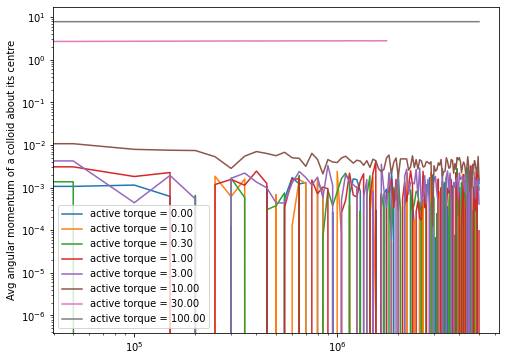

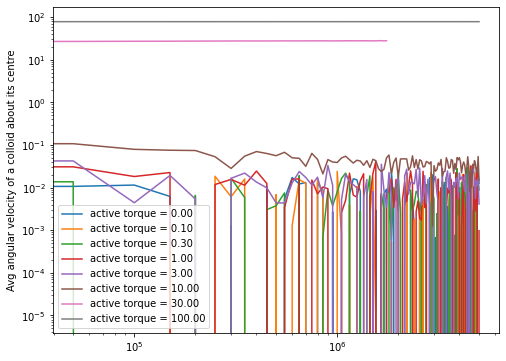

In [180]:
figAngMom=plt.figure(1,figsize=(8,6))
figOmega=plt.figure(2,figsize=(8,6))

for eT in eTList:
    key=createkey_rotstats(eT)
    data=rotdatadic[key]
    plt.figure(figAngMom)
    plt.plot(data['ts'].values,data['AngMomAvg'], label='active torque = {:.2f}'.format(eT))
    plt.ylabel('Avg angular momentum of a colloid about its centre')
    plt.figure(figOmega)
    plt.plot(data['ts'].values,data['OmegaAvg'], label='active torque = {:.2f}'.format(eT))
    plt.ylabel('Avg angular velocity of a colloid about its centre')
for fig in [figAngMom,figOmega]:
    plt.figure(fig)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    

# Old plots

In [20]:
def get_densdatadic(densList, RcylList, realrange, Lc, nC, cbP):

    densdatadic={}

    for dens in densList:
        
        densStr = densitystring(dens)
        datadic={}

        for Rcyl in RcylList:

            times = []
            Nbonds = []
            NbondsVar = []
            ClustersTmpDfs = []
            realcounter=0

            for real in realrange:
                if Rcyl==0:
                    filestring='Lc{:d}_dens{:s}_p_nC{:d}_cbP{:.3f}_{:d}'.format(Lc, densStr, nC, cbP, real)
                else:
                    filestring='Lc{:d}_dens{:s}_c_nC{:d}_Rcyl{:.1f}_cbP{:.3f}_{:d}'.format(Lc, densStr, nC, Rcyl, cbP, real)            
                bonds_file='../Results/Bonds_{}.dat'.format(filestring)
                clustersstatistics_file='ClustersFiles/ClustersStatistics_{}.dat'.format(filestring)
                if (os.path.isfile(clustersstatistics_file)==False):
                    print("Inexistant {}".format(filestring))
                    continue
                realcounter+=1
                print(filestring)
                j=0
                for time, columns, data, box, N in read_bonds(bonds_file):
                    if realcounter==1:
                        times.append(time)
                        Nbonds.append(N)
                        NbondsVar.append(N**2)
                    else:
                        assert time==times[j], "ERROR: {:d}-th time ({:d}, {:d}) does not correspond for file {:s}".format(j,time,times[j],bonds_file)
                        Nbonds[j] += N
                        NbondsVar[j] += N**2
                    j+=1
                ClustersTmpDfs.append(pd.read_csv(clustersstatistics_file, names=['ts','LargestSize_{:d}'.format(real),'AvgSize_{:d}'.format(real)],skiprows=1, sep=' ' ))

            Nbonds=np.array(Nbonds)/realcounter
            NbondsStd=np.sqrt(np.array(NbondsVar)/realcounter - Nbonds**2)
            NbondsDf = pd.DataFrame(np.array([times,Nbonds,NbondsStd]).transpose(), columns=['ts','mean','std'])

            LargestSizeDf = ClustersTmpDfs[0].iloc[:,[0,1]]
            AvgSizeDf = ClustersTmpDfs[0].iloc[:,[0,2]]
            for df in ClustersTmpDfs[1:]:
                assert (LargestSizeDf['ts'].values==df['ts']).all(), print(df['ts'])
                LargestSizeDf = pd.concat((LargestSizeDf, df.iloc[:,[1]]) ,axis=1)
                AvgSizeDf = pd.concat((AvgSizeDf, df.iloc[:,[2]]) ,axis=1)
            LargestSizeDf.iloc[:,1:] /= Lc+3
            tmpmean = LargestSizeDf.iloc[:,1:].mean(axis=1)
            tmpstd = LargestSizeDf.iloc[:,1:].std(axis=1)
            LargestSizeDf['mean'] = tmpmean
            LargestSizeDf['std'] = tmpstd
            AvgSizeDf.iloc[:,1:] /= Lc+3
            tmpmean = AvgSizeDf.iloc[:,1:].mean(axis=1)
            tmpstd = AvgSizeDf.iloc[:,1:].std(axis=1)
            AvgSizeDf['mean'] = tmpmean
            AvgSizeDf['std'] = tmpstd

            for real in realrange:
                if 'LargestSize_{:d}'.format(real) in LargestSizeDf.columns:
                    del LargestSizeDf['LargestSize_{:d}'.format(real)]
                    del AvgSizeDf['AvgSize_{:d}'.format(real)]

            datadic['{:.1f}'.format(Rcyl)]={}
            datadic['{:.1f}'.format(Rcyl)]['Nbonds']=NbondsDf
            datadic['{:.1f}'.format(Rcyl)]['LargestSize']=LargestSizeDf
            datadic['{:.1f}'.format(Rcyl)]['AvgSize']=AvgSizeDf

        densdatadic[densStr] = datadic
    
    return densdatadic

 ### Preliminary plots of number of bonds (Nbonds), largest cluster size (LargestSize), and average cluster size (AvgSize)

In [21]:
## Import Bonds files into a DataFrame, for all configurations (planar and cylindrical, all Rcyl) 

densList=[0.01, 0.005, 0.001]
#densStringList = ["{:.3f}".format(dens) for dens in densList]

RcylList=[0, 12.5, 15, 20, 25, 50, 100] # 0 stands for plane
#RcylStringList = ["{:.1f}".format(Rcyl) for Rcyl in RcylList]

realrange=range(100,105)

Lc, nC, cbP = 24, 200, 0.001

In [ ]:
densdatadic=get_densdatadic(densList, RcylList, realrange, Lc, nC, cbP)

Lc24_dens0.010_p_nC200_cbP0.001_100
Lc24_dens0.010_p_nC200_cbP0.001_101
Lc24_dens0.010_p_nC200_cbP0.001_102
Lc24_dens0.010_p_nC200_cbP0.001_103
Lc24_dens0.010_p_nC200_cbP0.001_104
Lc24_dens0.010_c_nC200_Rcyl12.5_cbP0.001_100
Lc24_dens0.010_c_nC200_Rcyl12.5_cbP0.001_101
Lc24_dens0.010_c_nC200_Rcyl12.5_cbP0.001_102
Lc24_dens0.010_c_nC200_Rcyl12.5_cbP0.001_103
Lc24_dens0.010_c_nC200_Rcyl12.5_cbP0.001_104
Lc24_dens0.010_c_nC200_Rcyl15.0_cbP0.001_100
Lc24_dens0.010_c_nC200_Rcyl15.0_cbP0.001_101
Lc24_dens0.010_c_nC200_Rcyl15.0_cbP0.001_102
Lc24_dens0.010_c_nC200_Rcyl15.0_cbP0.001_103
Lc24_dens0.010_c_nC200_Rcyl15.0_cbP0.001_104
Lc24_dens0.010_c_nC200_Rcyl20.0_cbP0.001_100
Lc24_dens0.010_c_nC200_Rcyl20.0_cbP0.001_101
Lc24_dens0.010_c_nC200_Rcyl20.0_cbP0.001_102
Lc24_dens0.010_c_nC200_Rcyl20.0_cbP0.001_103
Lc24_dens0.010_c_nC200_Rcyl20.0_cbP0.001_104
Lc24_dens0.010_c_nC200_Rcyl25.0_cbP0.001_100
Lc24_dens0.010_c_nC200_Rcyl25.0_cbP0.001_101
Lc24_dens0.010_c_nC200_Rcyl25.0_cbP0.001_102
Lc24_dens0